# This first example of sonifications uses Mido, a python package that helps you handle MIDI files. MIDI is a standard audio file format, you can read a bit about it [here](https://en.wikipedia.org/wiki/MIDI) , and you can find Mido [here](https://mido.readthedocs.io/en/stable/). In order to run this notebook, in addition to the standard fare of numpy etc, you'll need to install Mido, FFMPEG, fluidsynth, and PIL. FFMPEG is easiest to install with homebrew (though see the helpful hints [here](https://superuser.com/questions/624561/install-ffmpeg-on-os-x)), while fluidsynth is [here](https://www.fluidsynth.org)

The Mido-based approach to sonifying is basically just writing out a bunch of midi files and then converting them to real sounds using FFMPEG, fluidsynth, and a soundfont (aka a file with a bunch of audio clips for different instruments/synths). This approach requires more steps than the Strauss approach, but you can be extremely flexible with most aspects of the sonification. The duration of the notes is weirdly hard to control, despite being able to specify it in the file. 

In [1]:
import matplotlib.pyplot as plt
import IPython.display as ipd
import os
import numpy as np
import copy
import sys
sys.path.append('../')
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import time
import matplotlib.cm as cm

from mido import Message, MidiFile, MidiTrack
import mido

import time

from FLEX_ed import ExpandGalaxies, BeefIt


import ffmpeg
#import glob

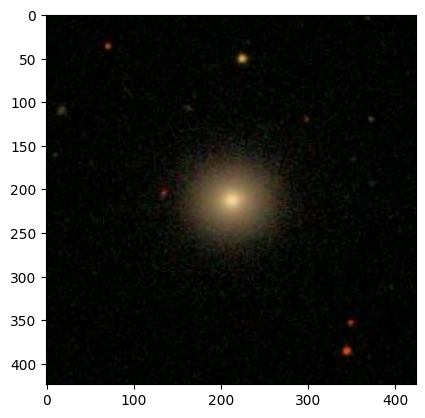

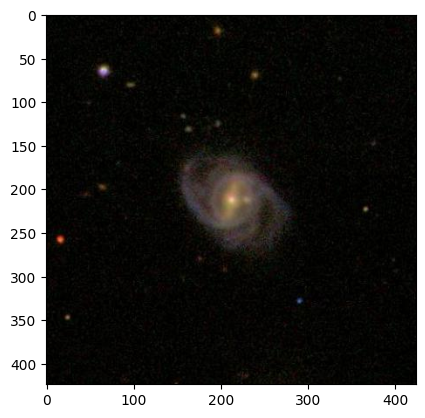

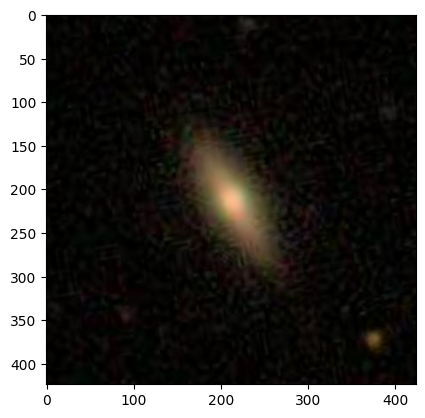

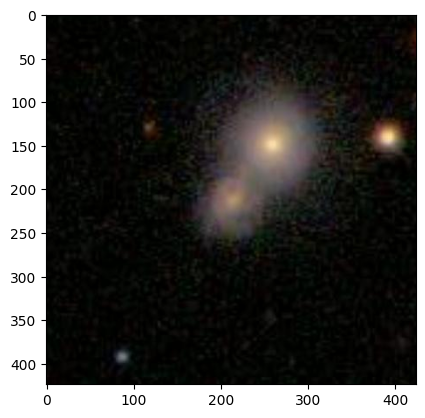

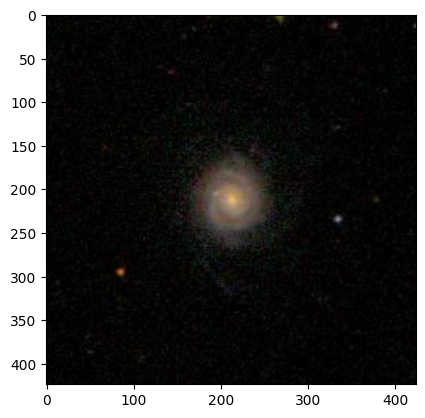

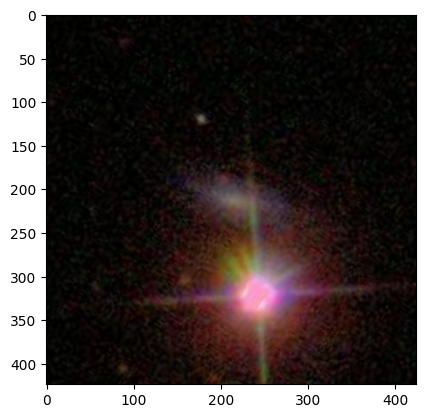

In [2]:
#visually inspecting our chosen galaxies
galaxies = ['GZ2_images/844.jpg', 'GZ2_images/290722.jpg', 'GZ2_images/99129.jpg','GZ2_images/289500.jpg', 'GZ2_images/295140.jpg',
            'GZ2_images/258142.jpg']
for image in galaxies:
    im = Image.open('../'+image)
    a = np.asarray(im)
    plt.figure()
    plt.imshow(a)

# The first step to doing a sonification is to pick a way to map the coefficients to sounds. In the example here, I map the 'n' dimension to notes and the 'm' dimension to instruments. I give a default set of twelve notes in an order that I think generally sounds good, but you can change this! 

# doing the mapping - >

In [3]:
#this function is super similar to our function on the strauss example
def mod_map_to_sounds_instruments_ampcutoff(cos_cos, sin_cos, \
                                            note_list = np.array(['D#','A#','F','C','G', 'D', 'A', 'E','B','F#','C#','G#'])):
    #here we set our octave explicitly, no longer is m
    #we also can read in a note list or default to my favorite one
    mmax = cos_cos.shape[0]
    nmax = cos_cos.shape[1]

    modulus = np.sqrt(cos_cos**2 + sin_cos**2)
    
    abs_max = np.max(modulus)
    note_dict = {}
    for m in range(mmax):
        instrument_channel = m #mapping instrument channels arbitrarily 
        octave = m + 1
        for n in range(nmax):
            amp = modulus[m,n]/modulus[0,0]
            if abs(amp) >= 0.01*(abs_max/modulus[0,0]): #will only play terms with amplitude at least 1% of max
                note = note_list[n] + str(octave) #still saving out octave info, why not
                note_dict[note] = instrument_channel #saving out instrument instead of amplitude
    return note_dict

#this is now going from nice note notation to midi number notation
def map_notes_to_midi_num(notes, fix_octave=True, octave=4):
    #option to fix the octave or to use the m-based octave from above
    midi_note_list = []
    channel_list = []
    for note_ in notes:
        note = note_[:-1] #getting just the note
        if fix_octave == True: 
            octave = octave
        else:
            octave = int(note_[-1])
        channel_list.append(notes[note_]) # map m to channel number
        #each note has a specific number in the MIDI file world
        if note == 'C':
            midi_note = 24
        elif note == 'C#':
            midi_note = 25
        elif note == 'D':
            midi_note = 26
        elif note == 'D#':
            midi_note = 27
        elif note == 'E':
            midi_note = 28
        elif note == 'F':
            midi_note = 29
        elif note == 'F#':
            midi_note = 30
        elif note == 'G':
            midi_note = 31
        elif note == 'G#':
            midi_note = 32
        elif note == 'A':
            midi_note = 33
        elif note == 'A#':
            midi_note = 34
        elif note == 'B':
            midi_note = 35
        #accounting for octave information - this just moves the note numbers up according to the octave
        if octave == 1:
            midi_note_list.append(midi_note)
        else:
            midi_note_list.append(midi_note + octave*12)
    return midi_note_list, channel_list


'''#making chords in midi format - this just ammounts to opening a file and adding a bunch of 'note on' and 'note off' commands.
def add_chord(track, notes, channels, duration, velocity=127): 
    #velocity here just means volume, and the max is 127. Not sure why?
    j = -1
    for note in notes:
        j += 1
        if channels[j] <= 2: 
            track.append(Message('note_on', note=note, velocity=60, channel=channels[j], time=0))
        else:
            track.append(Message('note_on', note=note, velocity=velocity, channel=channels[j], time=0))
        if channels[0] <= 2:
            track.append(Message('note_off', note=notes[0], velocity=60, channel=channels[0], time=duration))
        else:
            track.append(Message('note_off', note=notes[0], velocity=velocity, channel=channels[0], time=duration))
    k = 0
    for note in notes[1:]:
        k+=1
        if channels[k] <= 2:
            track.append(Message('note_off', note=note, velocity=60, channel=channels[k], time=duration))
        else:
            track.append(Message('note_off', note=note, velocity=velocity, channel=channels[k], time=duration))
'''

#making chords in midi format - this just ammounts to opening a file and adding a bunch of 'note on' and 'note off' commands.
def add_chord(track, notes, channels, duration, velocity=127): 
    #velocity here just means volume, and the max is 127
    #duration is total time, channels is how we can do different instruments
    j = -1
    for note in notes:
        j += 1
        track.append(Message('note_on', note=note, velocity=velocity, channel=channels[j], time=0))
        track.append(Message('note_off', note=note, velocity=velocity, channel=channels[j], time=duration))

#starting each note at a slightly different time, determined by roll_spacing
def add_rolled_chord(track, notes, channels, duration, m, velocity=127):
    j = -1
    roll_spacing = 20
    
    for note in notes:
        j += 1
        track.append(Message('note_on', note=note, velocity=velocity, channel=channels[j], time=int(m[j]*roll_spacing)))
    track.append(Message('note_off', note=notes[0], velocity=velocity, channel=channels[0], time=duration))
    k = 0
    for note in notes[1:]:
        k+=1
        track.append(Message('note_off', note=note, velocity=velocity, channel=channels[k], time=duration))
                     

#putting everything together, the whole shebang
def make_midi_chords(note_names, chord_length, outputfile, fix_octave=True, octave=2, 
                     program_list= [1, 16, 79, 16, 76, 113, 124], roll=False):
    #here, program_lists is numbers corresponding to the different midi instruments (see the Wiki page at the top)
    #need to take in chords in Strauss format, i.e. [[chord],[chord],[etc]] for compatability
    #making the midi file etc
    mid = MidiFile()
    track = MidiTrack()
    mid.tracks.append(track)

    # Set the tempo (optional, here 120 BPM)
    tempo = mido.bpm2tempo(120)
    track.append(mido.MetaMessage('set_tempo', tempo=tempo))

    # Insert program change at the beginning of the track, the max number of midi channels is 16 but here I'm going out to 7
    #- this is bad hard coding assuming that the instrument is the m direction and that mmax is 7...
    program_change = mido.Message('program_change', program=program_list[0],channel=0) 
    track.insert(0, program_change) #bank zero, program change
    #these weird banks and program change things are how you get the different instruments to actually play
    program_change = mido.Message('program_change', program=program_list[1],channel=1) 
    track.insert(0, program_change) #bank zero, program change
    program_change = mido.Message('program_change', program=program_list[2],channel=2) 
    track.insert(0, program_change) #bank zero, program change
    program_change = mido.Message('program_change', program=program_list[3],channel=3) 
    track.insert(0, program_change) #bank zero, program change
    program_change = mido.Message('program_change', program=program_list[4],channel=4) 
    track.insert(0, program_change) #bank zero, program change
    program_change = mido.Message('program_change', program=program_list[5],channel=5) 
    track.insert(0, program_change) #bank zero, program change
    program_change = mido.Message('program_change', program=program_list[6],channel=6) 
    track.insert(0, program_change) #bank zero, program change
    #do you want all notes to start at once or do you want to add them up over time
    for chord in note_names:
        if roll == False:
            notes, channels = map_notes_to_midi_num(chord, fix_octave=fix_octave, octave=octave)
            add_chord(track, notes, channels, chord_length)
        else:
            notes, channels = map_notes_to_midi_num(chord, fix_octave=fix_octave, octave=octave)
            add_rolled_chord(track, notes, channels, chord_length, channels)
    # Save the MIDI file
    print('length', mid.length)
    print(mid)
    mid.save(outputfile)

opening image
Reff =  29.11686406230761  Galaxy Radius:  174.70118437384565
getting pixel info, galaxy radius, mask, etc
finding center of image
center of mass estimate 1.1765405126063389 -1.6052432754683108
center finding iteration 0
center finding iteration 50
Center of mass at x = 1.4309032385321974, y = 1.0822956657103904
finding best rscl
New rscl value: 29
updating to new_mmax, new_nmax


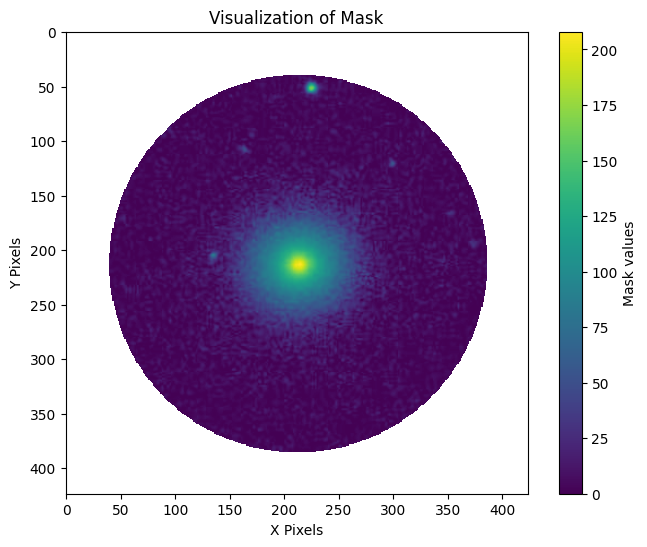

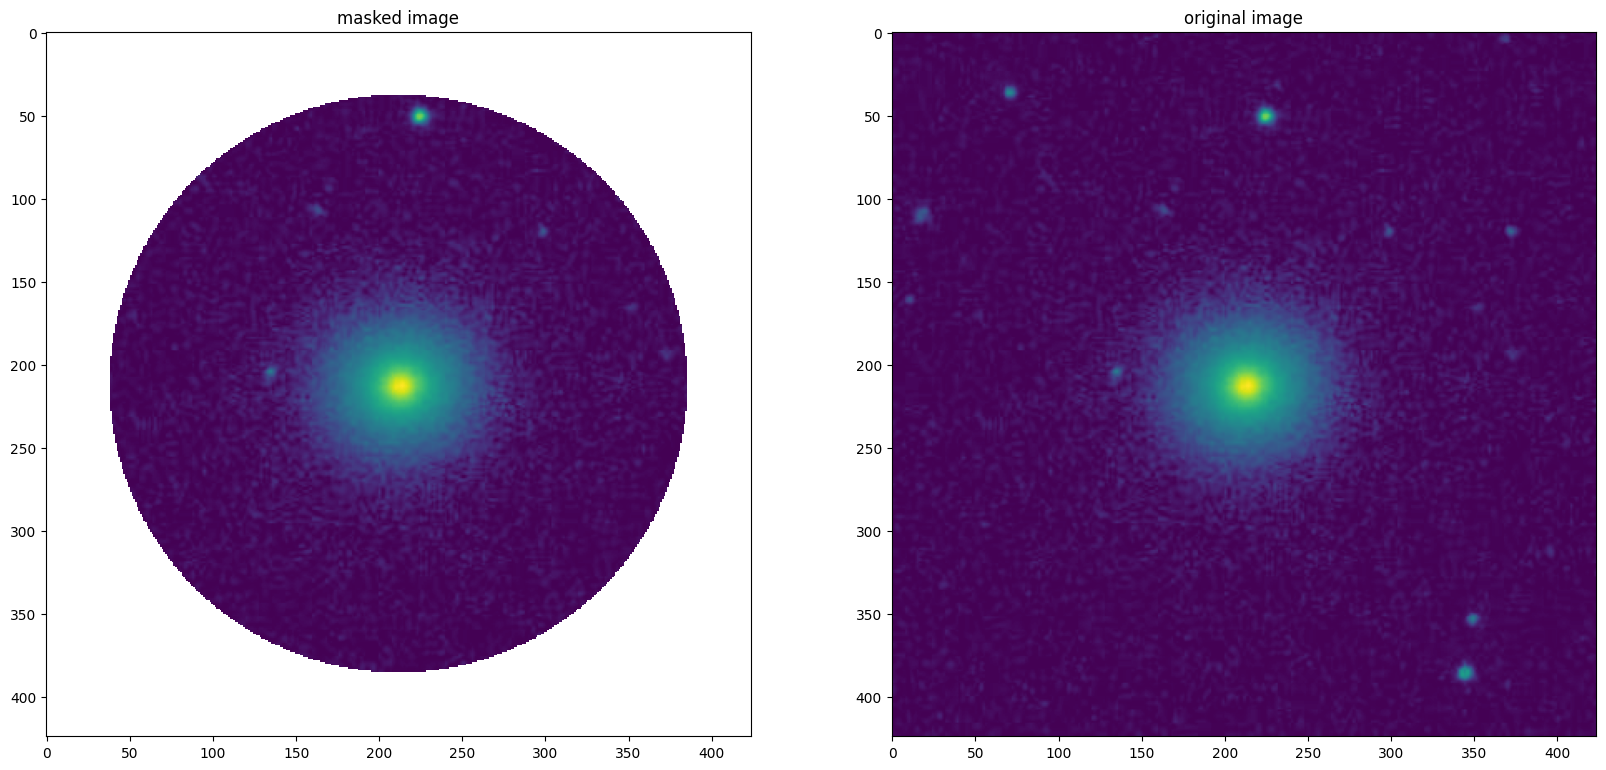

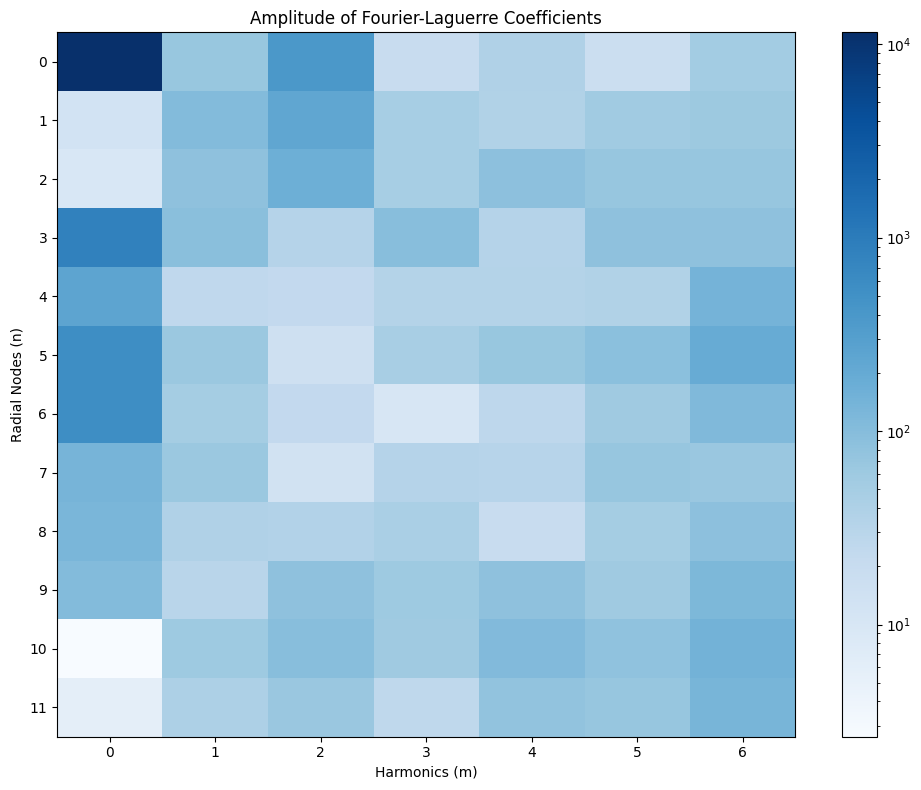

/Users/cfilion/Developer/sonification/SummerProjects/FLEX_ed.py:721: RuntimeWarning: divide by zero encountered in divide
  ax3.imshow(((reconstruction - fixed_image) / fixed_image).T,cmap='bwr',vmin=-1,vmax=1)


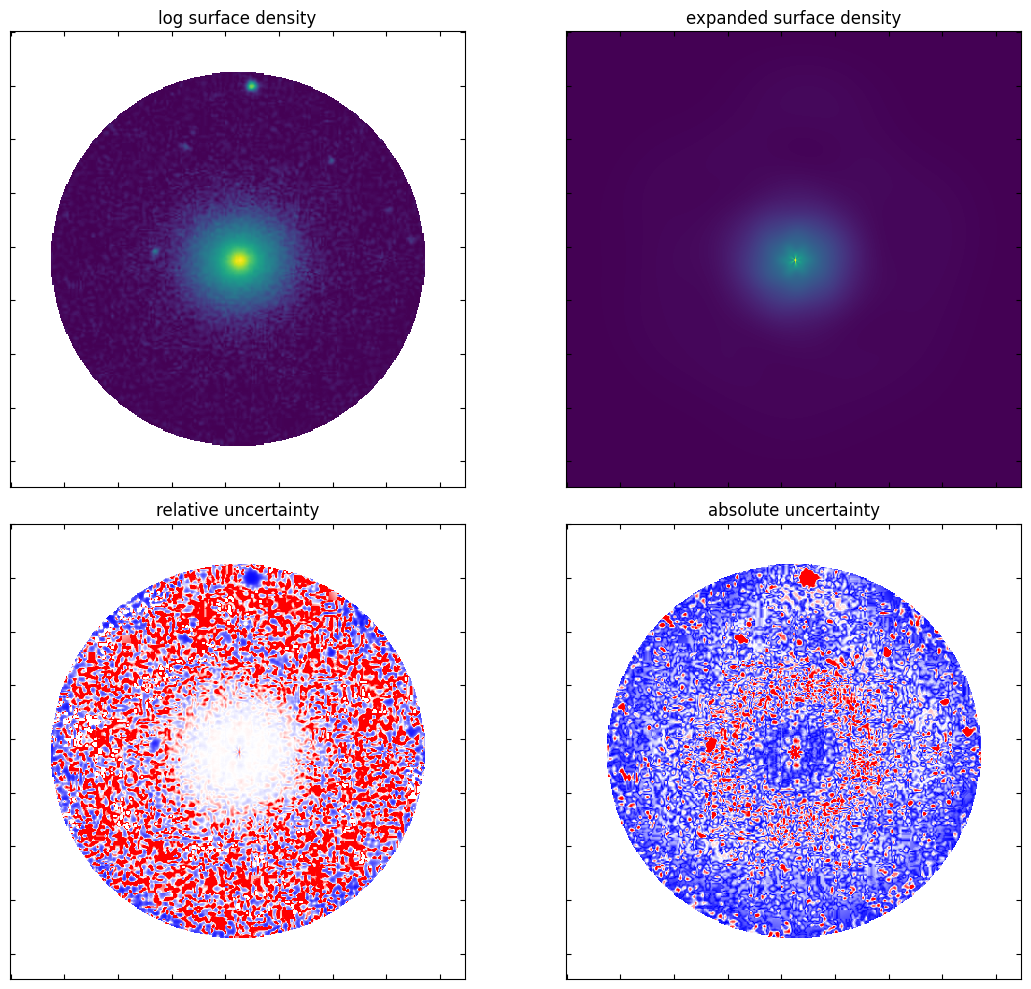

returning cosine coefficients, sine coefficients
length 0.3125
MidiFile(type=1, ticks_per_beat=480, tracks=[
  MidiTrack([
    Message('program_change', channel=6, program=124, time=0),
    Message('program_change', channel=5, program=113, time=0),
    Message('program_change', channel=4, program=76, time=0),
    Message('program_change', channel=3, program=16, time=0),
    Message('program_change', channel=2, program=79, time=0),
    Message('program_change', channel=1, program=16, time=0),
    Message('program_change', channel=0, program=1, time=0),
    MetaMessage('set_tempo', tempo=500000, time=0),
    Message('note_on', channel=0, note=51, velocity=127, time=0),
    Message('note_off', channel=0, note=51, velocity=127, time=20),
    Message('note_on', channel=0, note=48, velocity=127, time=0),
    Message('note_off', channel=0, note=48, velocity=127, time=20),
    Message('note_on', channel=0, note=55, velocity=127, time=0),
    Message('note_off', channel=0, note=55, velocity=127

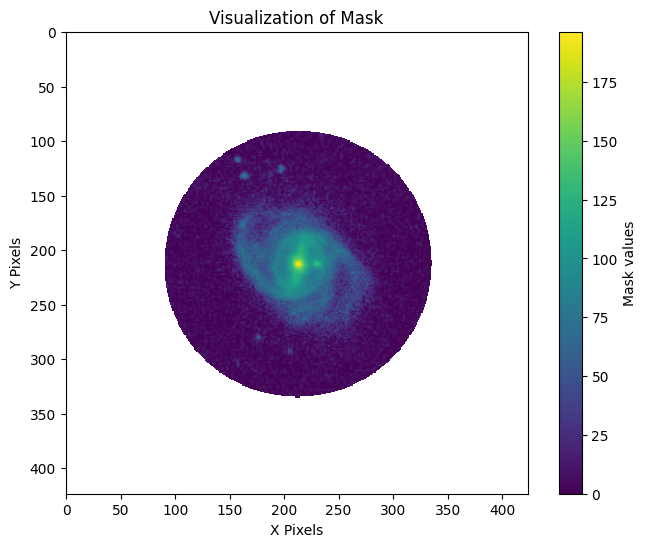

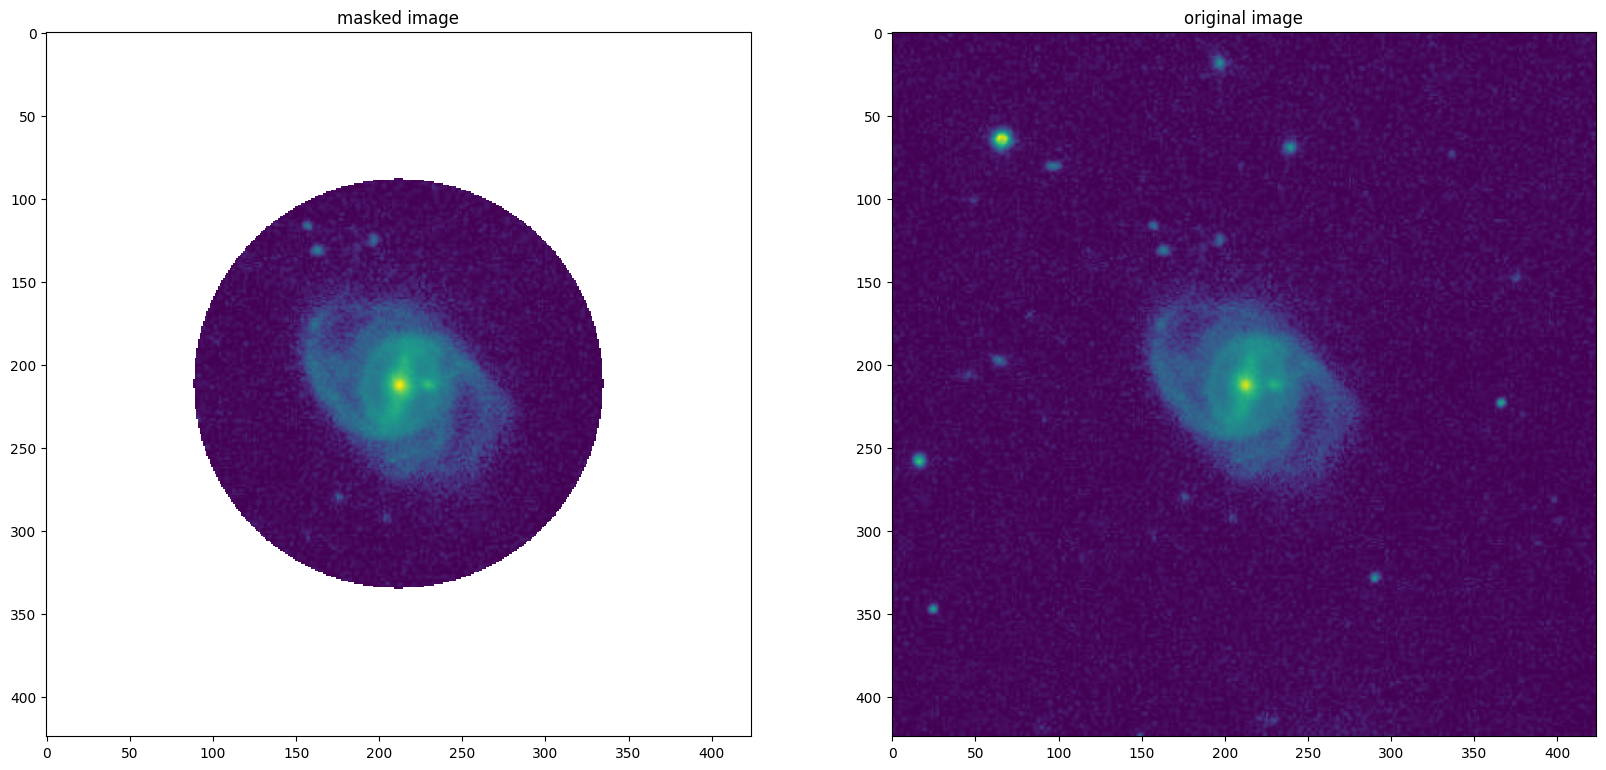

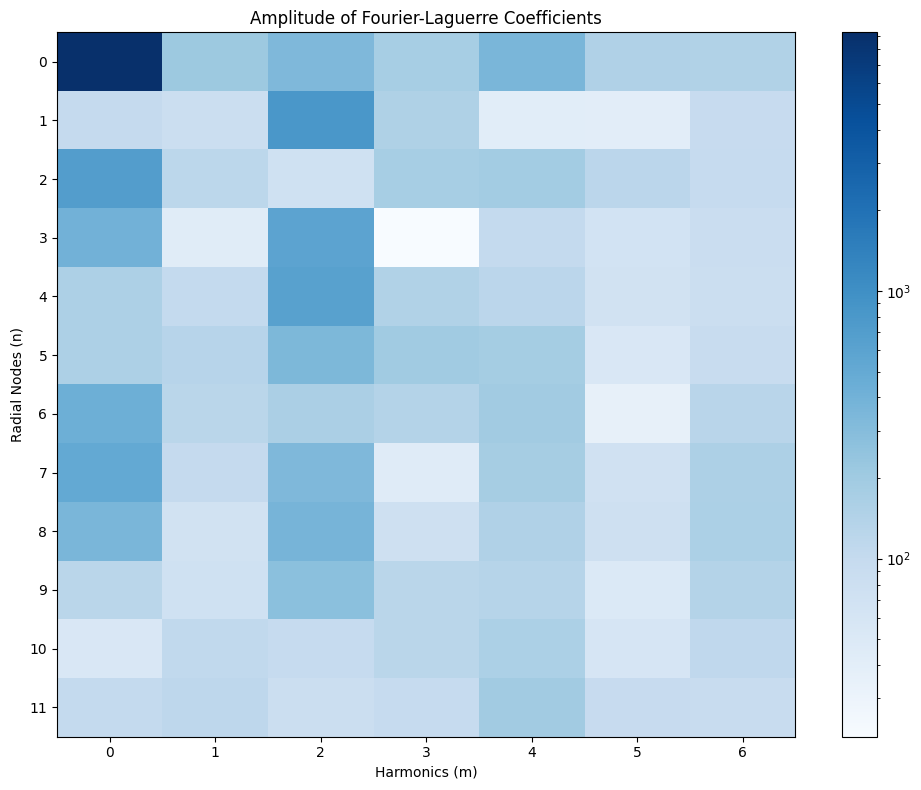

/Users/cfilion/Developer/sonification/SummerProjects/FLEX_ed.py:721: RuntimeWarning: divide by zero encountered in divide
  ax3.imshow(((reconstruction - fixed_image) / fixed_image).T,cmap='bwr',vmin=-1,vmax=1)


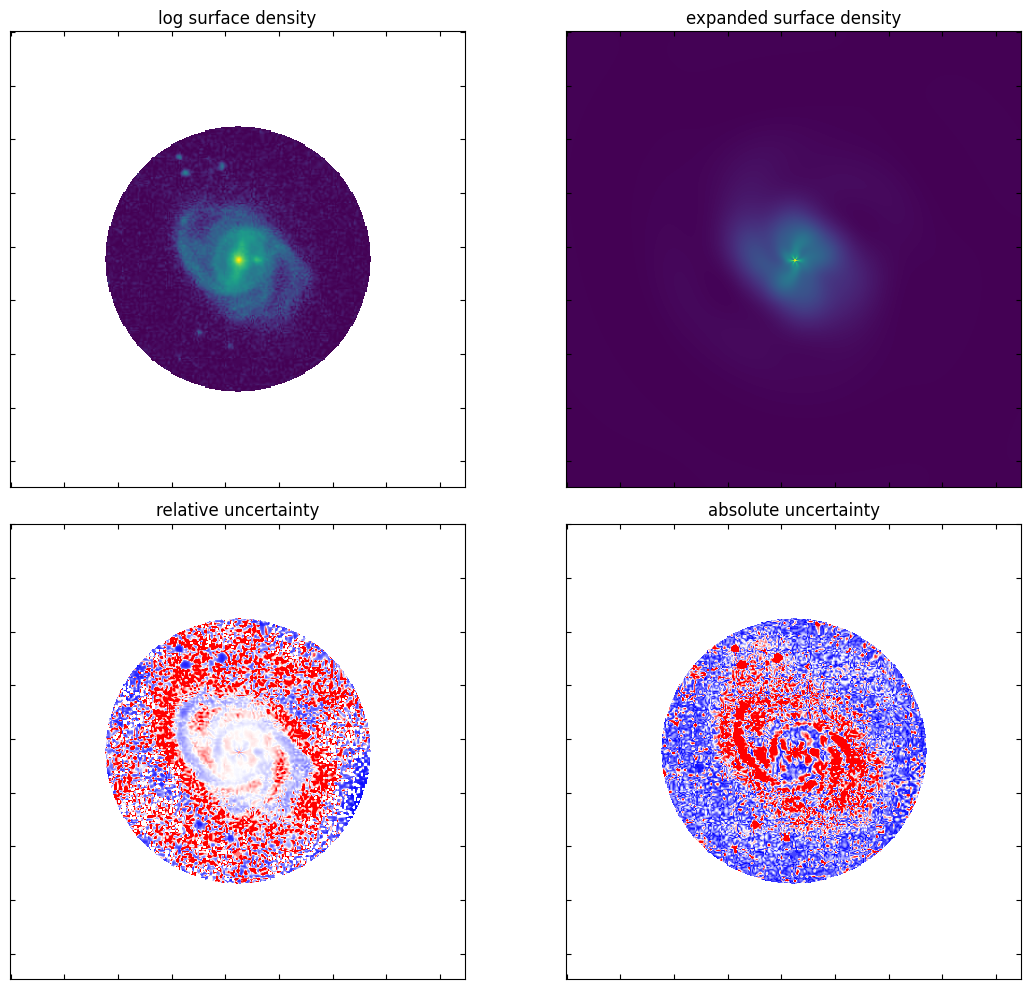

returning cosine coefficients, sine coefficients
length 1.2708333333333333
MidiFile(type=1, ticks_per_beat=480, tracks=[
  MidiTrack([
    Message('program_change', channel=6, program=124, time=0),
    Message('program_change', channel=5, program=113, time=0),
    Message('program_change', channel=4, program=76, time=0),
    Message('program_change', channel=3, program=16, time=0),
    Message('program_change', channel=2, program=79, time=0),
    Message('program_change', channel=1, program=16, time=0),
    Message('program_change', channel=0, program=1, time=0),
    MetaMessage('set_tempo', tempo=500000, time=0),
    Message('note_on', channel=0, note=51, velocity=127, time=0),
    Message('note_off', channel=0, note=51, velocity=127, time=20),
    Message('note_on', channel=0, note=58, velocity=127, time=0),
    Message('note_off', channel=0, note=58, velocity=127, time=20),
    Message('note_on', channel=0, note=53, velocity=127, time=0),
    Message('note_off', channel=0, note=53, 

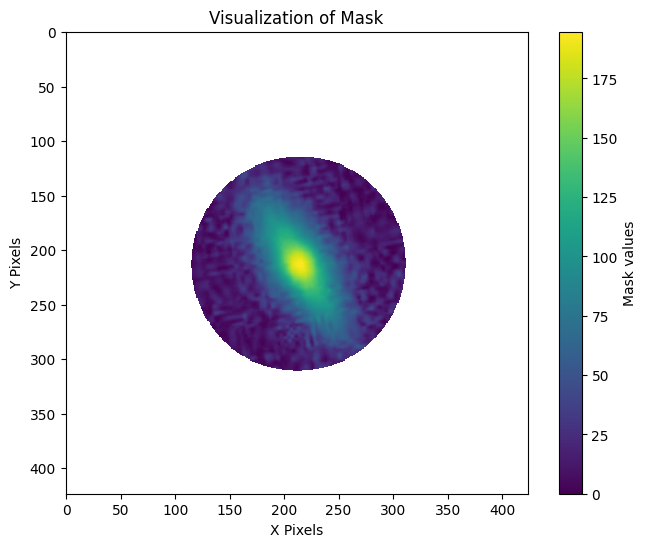

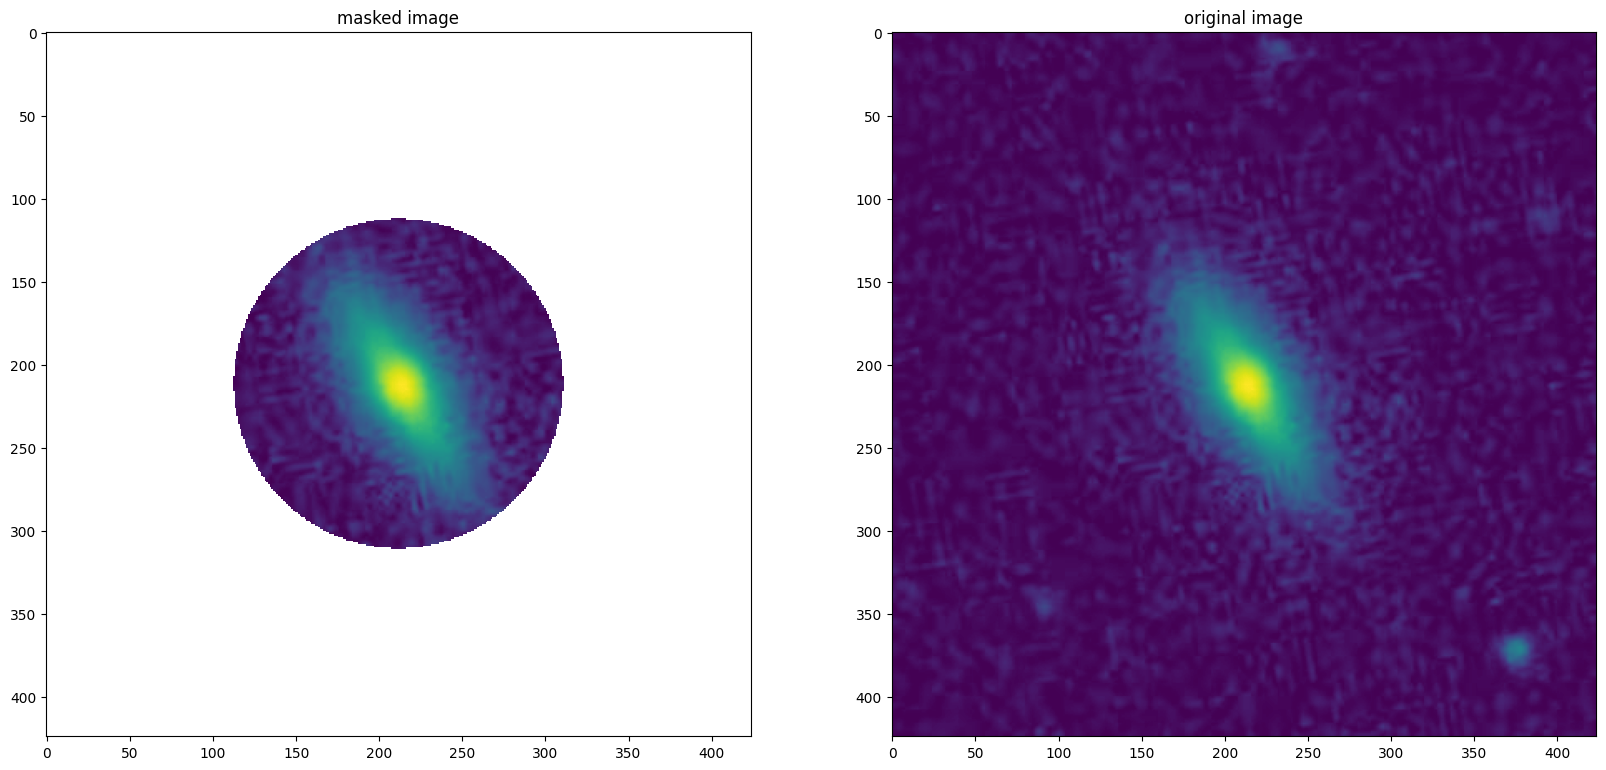

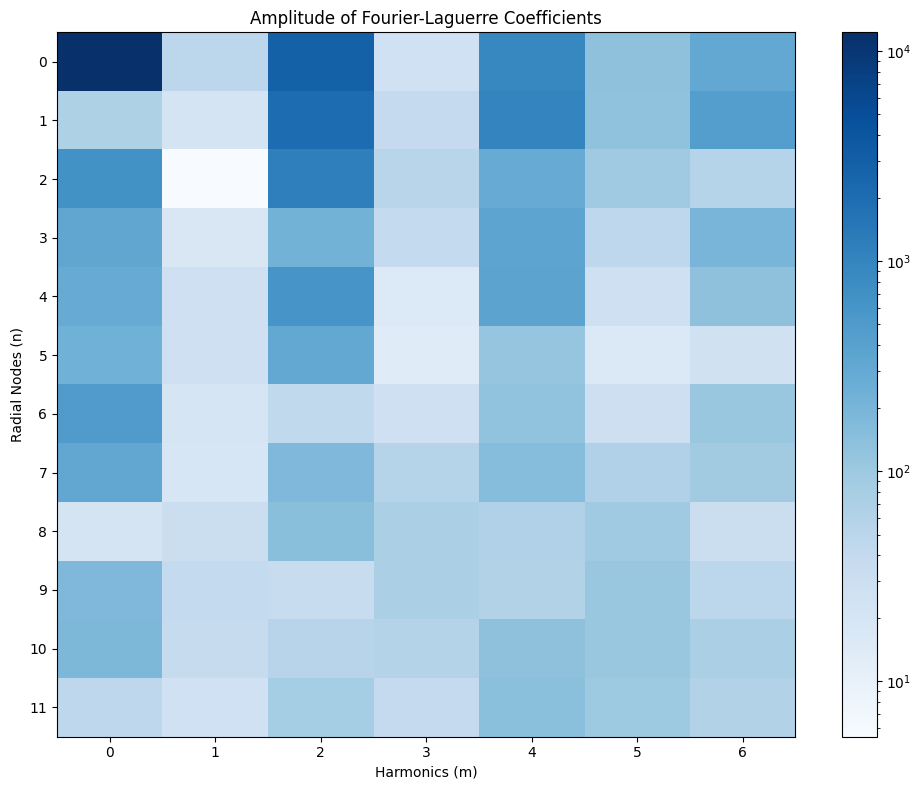

/Users/cfilion/Developer/sonification/SummerProjects/FLEX_ed.py:721: RuntimeWarning: divide by zero encountered in divide
  ax3.imshow(((reconstruction - fixed_image) / fixed_image).T,cmap='bwr',vmin=-1,vmax=1)


KeyboardInterrupt: 

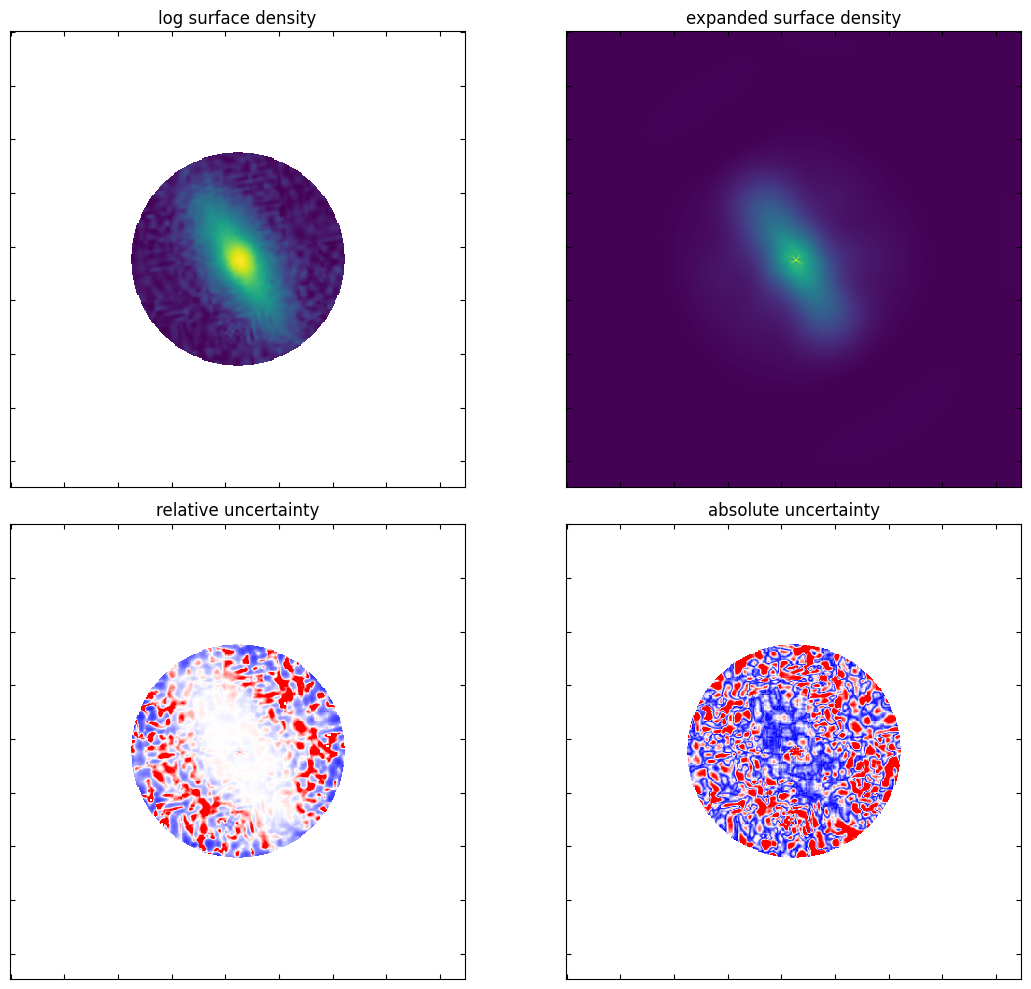

In [6]:
coefs = {}
name_list = []
length = 3
for image in galaxies:
    #assuming mmax = 7 nmax = 12  
    cos_cos712, sin_cos712 = BeefIt('../'+str(image), rscl_initial = 10, 
                                        mmax_initial = 2, nmax_initial = 10,
                                       new_mmax = 7, new_nmax = 12)

    notes = mod_map_to_sounds_instruments_ampcutoff(cos_cos712, sin_cos712)

    #getting galaxy number/name for file name
    image_name = image.split('/')[1]
    image_name = image_name.split('.')[0]
    #making wav file, plugging in soundfont then converting to wav    
    make_midi_chords([notes], 20, str(image_name)+'_testing.mid', octave = 2, roll=False) 
    #turning into .wav file
    ! fluidsynth "../GeneralUser-GS.sf2" -L 7 -F {str(image_name)}_'testing.wav' {str(image_name)}_'testing.mid'
    #converting to mp3 - uncomment if you want this
    #! fluidsynth -F "{image_name}_testing" "../GeneralUser-GS.sf2" "{image_name}_testing.mid" && \
    #    lame "{image_name}_testing"
    #os.remove(str(image_name)+'_'+str(gt)+'_testing.mid')


# some scratch code for testing different sounds...

In [112]:
program_list = [1, 59, 14, 72, 69, 74, 113]
#need to take in chords in Strauss format, i.e. [[chord],[chord],[etc]]
# Create a new MIDI file and track
#[44, 71, 43, 72, 42, 69, 74]
mid = MidiFile()
track = MidiTrack()
mid.tracks.append(track)

# Set the tempo (optional, here 120 BPM)
tempo = mido.bpm2tempo(120)
track.append(mido.MetaMessage('set_tempo', tempo=tempo))

# Insert program change at the beginning of the track
program_change = mido.Message('program_change', program=program_list[0],channel=0) 
track.insert(0, program_change) #bank zero, program change
program_change = mido.Message('program_change', program=program_list[1],channel=1) 
track.insert(0, program_change) #bank zero, program change
program_change = mido.Message('program_change', program=program_list[2],channel=2) 
track.insert(0, program_change) #bank zero, program change
program_change = mido.Message('program_change', program=program_list[3],channel=3) 
track.insert(0, program_change) #bank zero, program change
program_change = mido.Message('program_change', program=program_list[4],channel=4) 
track.insert(0, program_change) #bank zero, program change
program_change = mido.Message('program_change', program=program_list[5],channel=5) 
track.insert(0, program_change) #bank zero, program change
program_change = mido.Message('program_change', program=program_list[6],channel=6) 
track.insert(0, program_change) #bank zero, program change


track.append(Message('note_on', note=53, velocity=127, channel=0, time=0))
track.append(Message('note_on', note=53, velocity=127, channel=1, time=0))
track.append(Message('note_on', note=53, velocity=127, channel=2, time=0))
track.append(Message('note_on', note=53, velocity=127, channel=3, time=0))
track.append(Message('note_on', note=53, velocity=127, channel=4, time=0))
track.append(Message('note_on', note=53, velocity=127, channel=5, time=0))
track.append(Message('note_on', note=53, velocity=127, channel=6, time=0))
track.append(Message('note_off', note=53, velocity=127, channel=0, time=200))
track.append(Message('note_off', note=53, velocity=127, channel=1, time=200))
track.append(Message('note_off', note=53, velocity=127, channel=2, time=200))
track.append(Message('note_off', note=53, velocity=127, channel=3, time=200))
track.append(Message('note_off', note=53, velocity=127, channel=4, time=200))
track.append(Message('note_off', note=53, velocity=127, channel=5, time=200))
track.append(Message('note_off', note=53, velocity=127, channel=6, time=200))
mid.save('test.mid')